In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as util
import model.models as models
import feature.make_binary_dataset as make_binary_dataset
import numpy as np
import torch
import sacred
import tqdm
import matplotlib.pyplot as plt
import plotting.plots as plots

In [2]:
grad_ex = sacred.Experiment("grad", ingredients=[
    make_binary_dataset.dataset_ex
], interactive=True)

In [3]:
model_path = "/users/amtseng/att_priors/models/trained_models/SPI1_DREAM/1/model_ckpt_epoch_8.pt"
model_path = "/users/amtseng/att_priors/models/trained_models/SPI1_DREAM/23/model_ckpt_epoch_3.pt"
bed_path = "/users/amtseng/att_priors/data/SPI1_test_2000.tsv.gz"
reference_fasta_path = "/users/amtseng/genomes/hg19.fasta"

In [4]:
@grad_ex.capture
def get_data_loader(
    bedpath, reference_fasta_path, batch_size=1, convert_states=True
):
    """
    From the path to a gzipped BED containing values, this function returns a
    data loader.
    """
    return make_binary_dataset.data_loader_from_bedfile(
        bedpath, batch_size=batch_size, reference_fasta=reference_fasta_path,
        negative_stride=1, num_workers=0, convert_states=convert_states,
        augment=False, shuffle=False
)

In [5]:
@grad_ex.main
def main():
    global grads, labels
    

    model = util.restore_model(models.BinaryTFBindingPredictor, model_path)

    if torch.cuda.is_available():
        model = model.cuda()
    
    data_loader = get_data_loader(bed_path, reference_fasta_path)
    data_loader.dataset.on_epoch_start()
            
    model.eval()  # Switch to evaluation mode
    
    num_batches = len(data_loader.dataset)
    for input_seqs, output_vals in tqdm.tqdm_notebook(data_loader, total=num_batches):
        input_seqs = util.place_tensor(torch.tensor(input_seqs)).float() 
        input_seqs = torch.transpose(input_seqs, 1, 2)

        input_seqs.requires_grad = True

        probs = model(input_seqs)

        probs.backward()

        input_grads = input_seqs.grad
        input_grads = torch.transpose(input_grads, 1, 2)

        input_grads = input_grads.cpu().detach().numpy()
        grads.append(input_grads)
        labels.append(output_vals)

    grads, labels = np.concatenate(grads), np.concatenate(labels)

In [6]:
grads, labels = [], []
grad_ex.run()
neg_grads = grads[np.where(labels == 0)[0]]
pos_grads = grads[np.where(labels == 1)[0]]

WARNING - grad - No observers have been added to this run
INFO - grad - Running command 'main'
INFO - grad - Started


	Reading in BED file... 0s
	Setting index... 0s
	Converting states to values... 0s
	Getting positive and negative rows... 0s
	Getting positive and negative counts... 0s
	Total coordinate counts by entry: 1000 + and 1000 -
	Total coordinate counts by row: 1000 + and 1000 -
	Estimated downsampled counts by row: 1000 + and 1000 -
	Sorting coordinates for downsampling... 0s


INFO - grad - Completed after 0:00:42


In [7]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [8]:
def plot_grad_and_fft(grads, include_dc=False):
    assert len(grads.shape) == 2
    grads = grads.copy()  # Make a copy
    grads[grads < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grads = np.max(grads, axis=1)
    freqs, mags = dft(grads)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal and the DFT
    fig, ax = plt.subplots(2, 1, figsize=(12, 5))
    ax[0].plot(np.arange(len(grads)), grads, color="blue")
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("max(ReLU(grad))")
    ax[1].plot(freqs, mags, color="red")
    ax[1].set_xlabel("Frequency (radians)")
    ax[1].set_ylabel("|Frequency component|")
    plt.tight_layout()
    plt.show(block=False)
    
    return freqs, mags

WARNING - matplotlib.font_manager - findfont: Font family ['Laksaman', 'Verdana', 'Arial'] not found. Falling back to DejaVu Sans.


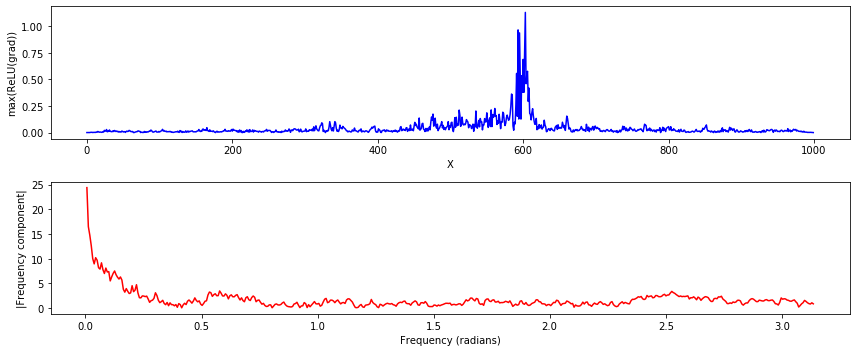

[0.00628319 0.01256637 0.01884956 0.02513274 0.03141593 0.03769911
 0.0439823  0.05026548 0.05654867 0.06283185]
[24.380423  16.495008  14.754655  12.630697  10.016735   8.965279
 10.217575   9.715732   8.194602   7.9075174]


In [9]:
freqs, mags = plot_grad_and_fft(pos_grads[0])
print(freqs[:10])
print(mags[:10])

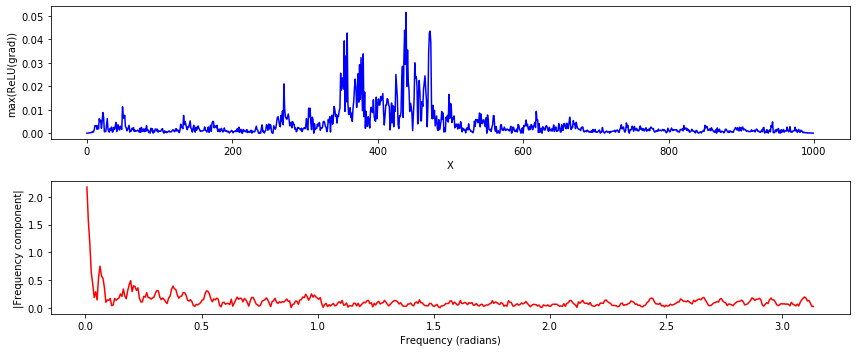

[0.00628319 0.01256637 0.01884956 0.02513274 0.03141593 0.03769911
 0.0439823  0.05026548 0.05654867 0.06283185]
[2.1743662  1.5593438  1.1649753  0.63728863 0.4356652  0.18844515
 0.29140988 0.14471601 0.55262953 0.7512258 ]


In [10]:
freqs, mags = plot_grad_and_fft(pos_grads[1])
print(freqs[:10])
print(mags[:10])

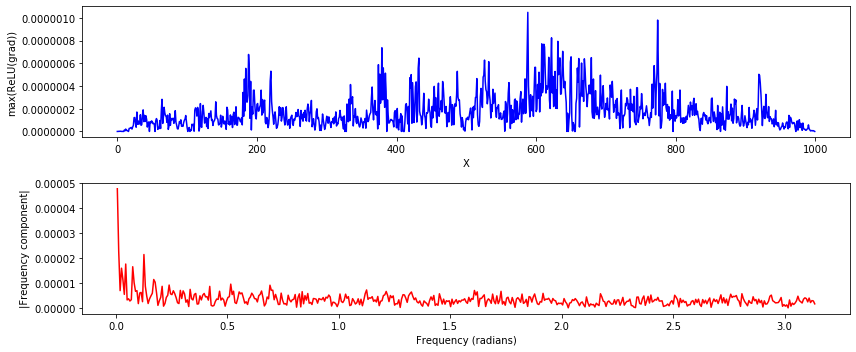

[0.00628319 0.01256637 0.01884956 0.02513274 0.03141593 0.03769911
 0.0439823  0.05026548 0.05654867 0.06283185]
[4.7784535e-05 2.2640126e-05 6.9609487e-06 1.5949909e-05 1.1330521e-05
 5.4653615e-06 1.7622211e-05 3.2512576e-06 3.7036423e-06 2.8047316e-06]


In [11]:
freqs, mags = plot_grad_and_fft(neg_grads[0])
print(freqs[:10])
print(mags[:10])

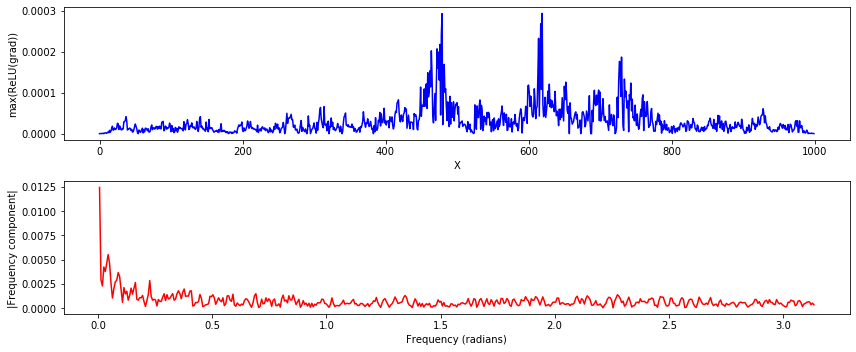

[0.00628319 0.01256637 0.01884956 0.02513274 0.03141593 0.03769911
 0.0439823  0.05026548 0.05654867 0.06283185]
[0.01243324 0.00291448 0.00229258 0.00424031 0.00378231 0.00461287
 0.00551619 0.00460644 0.00253662 0.00105039]


In [12]:
freqs, mags = plot_grad_and_fft(neg_grads[1])
print(freqs[:10])
print(mags[:10])

In [13]:
def grad_score_neg(grad):
    """
    Computes score for a negative example given the gradients.
    """
    assert len(grad.shape) == 2
    grad = grad.copy()  # Make a copy
    grad[grad < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grad = np.max(grad, axis=1)
    
    # The entire signal should be as close to 0 as possible
    return np.sum(grad)

In [34]:
def grad_score_pos(grad, freq_limit=0.5):
    """
    Computes score for a positive example given the gradients.
    """
    assert len(grad.shape) == 2
    grad = grad.copy()  # Make a copy
    grad[grad < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grad = np.max(grad, axis=1)
    freqs, mags = dft(grad)
    
    freqs, mags = freqs[1:], mags[1:]  # Exclude DC
    
    if np.sum(mags):
        mags = mags / np.sum(mags)  # Normalize
    
    # Sum up the area under the low-frequency region
    return np.sum(mags[freqs <= freq_limit])

In [39]:
def plot_score_distributions(pos_grads, neg_grads):
    neg_losses_on_pos = [grad_score_neg(grad) for grad in pos_grads]
    neg_losses_on_neg = [grad_score_neg(grad) for grad in neg_grads]
    pos_losses_on_pos = [grad_score_pos(grad) for grad in pos_grads]
    pos_losses_on_neg = [grad_score_pos(grad) for grad in neg_grads]
    plots.plot_multi_histogram(
        [neg_losses_on_pos, neg_losses_on_neg], ["Positives", "Negatives"], 2, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Rectified gradient sum", xlabel="Score"
    
    )
    plots.plot_multi_histogram(
        [pos_losses_on_pos, pos_losses_on_neg], ["Positives", "Negatives"], 0.02, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Sum of low frequency Fourier coefficients on gradients", xlabel="Score"
    )
    

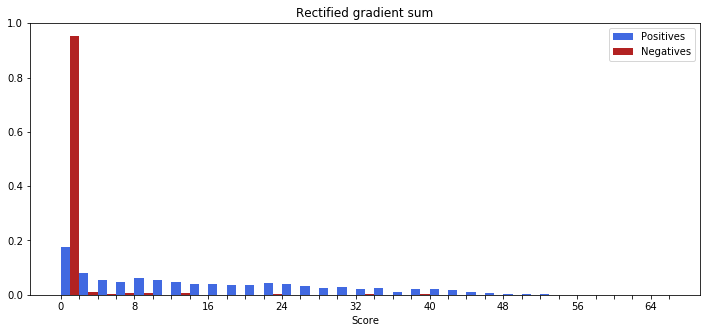

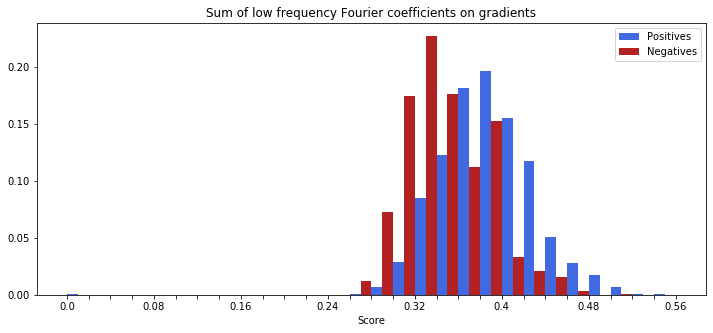

In [40]:
plot_score_distributions(pos_grads, neg_grads)